## Attempt at Pink Floyd DSOTM coverart reproduction

Ingredients: Fresnel equations, wavelength-dependent index of refraction, blackbody spectral density, and wavelength-to-RGB mixing and conversion. 

Try to replicate the classic Pink Floyd *The Dark Side of the Moon* (https://en.wikipedia.org/wiki/The_Dark_Side_of_the_Moon) coverart (by this artist: https://en.wikipedia.org/wiki/Storm_Thorgerson) using standard off-the-shelf ray optics computational formulas.

Reference for wavelength-to-color operations is found here: https://www.fourmilab.ch/documents/specrend/

Reference for wavelength-dependent index of refraction for Prism material: https://en.wikipedia.org/wiki/Cauchy%27s_equation

The simplest form of Cauchy's equation states
$$n(\lambda) \approx A + \frac{B}{\lambda^2}$$
where $A$ and $B$ are material constants.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import npdraw

plt.rcParams['figure.figsize'] = (6.4, 4.8)
print(plt.rcParams['figure.figsize'])

[6.4, 4.8]


In [2]:
# https://en.wikipedia.org/wiki/Fresnel_equations
def fresnel_power_coefs(thetai, thetat, n1, n2): # incident, transmitted angles
    Rs = ((n1 * np.cos(thetai) - n2 * np.cos(thetat)) / (n1 * np.cos(thetai) + n2 * np.cos(thetat))) ** 2
    Rp = ((n1 * np.cos(thetat) - n2 * np.cos(thetai)) / (n1 * np.cos(thetat) + n2 * np.cos(thetai))) ** 2
    Reff = (Rs + Rp) / 2.0
    return Reff, 1.0 - Reff  # reflected, transmitted powers for randomly polarized light

def transmitted_angle(thetai, n1, n2):  # Snell's law: n1 * sin(thetai) = n2 * sin(thetat)
    return np.arcsin(n1 * np.sin(thetai) / n2)

def make_unit_vector(phi):
    return np.array([np.cos(phi), np.sin(phi)])

def get_delta_angle(u, v): # differential angle btw. unit vector u, v, as CCW from u
    a = u[0] * v[0] + u[1] * v[1]
    b = u[0] * v[1] - u[1] * v[0]
    return np.arctan2(b, a)

# intersect ray from P along u with the ray from Q along v
def intersect_rays(P, u, Q, v):
    vperp = np.array([-v[1], v[0]])
    pmq = np.array([P[0] - Q[0], P[1] - Q[1]])
    c1 = pmq[0] * vperp[0] + pmq[1] * vperp[1]
    c2 = u[0] * vperp[0] + u[1] * vperp[1]
    s = -c1 / c2 # solve c1 + c2 * s = 0
    R = np.array([P[0] + s * u[0], P[1] + s * u[1]])
    return R

def tr_vectors(V, N, n1 = 1.0, n2 = 1.0): # N should be a unit normal vector
    thetai = get_delta_angle(N, V)
    thetat = transmitted_angle(thetai, n1, n2)
    assert np.isfinite(thetat)
    Reff, Teff = fresnel_power_coefs(thetai, thetat, n1, n2)
    d = np.sum(V * N)
    assert d > 0
    Q = V - d * N  # tangential vector
    R = V - 2 * Q  # reflected vector
    Q = Q / np.sqrt(np.sum(Q ** 2))
    atht = np.abs(thetat)
    T = np.cos(atht) * (-N) + np.sin(atht) * (-Q)  # transmitted vector
    return T, R, Reff, Teff

def plot_vector(V, P = None, lwdth = 1.0, color = 'black', alpha = 1.0):
    if P is None:
        plt.plot([0, V[0]], [0, V[1]], c = color, alpha = alpha, linewidth = lwdth)
    else:
        plt.plot([P[0], P[0] + V[0]], [P[1], P[1] + V[1]], c = color, alpha = alpha, linewidth = lwdth)

def plot_triangle(A, B, C, lwdth = 1.0, color = 'black', alpha = 1.0):
    plt.plot([A[0], B[0]], [A[1], B[1]], c = color, alpha = alpha, linewidth = lwdth)
    plt.plot([B[0], C[0]], [B[1], C[1]], c = color, alpha = alpha, linewidth = lwdth)
    plt.plot([C[0], A[0]], [C[1], A[1]], c = color, alpha = alpha, linewidth = lwdth)

def ior_from_wavelength(nanometer, materialName = 'BK7'):
    # https://en.wikipedia.org/wiki/Cauchy%27s_equation
    cauchy_parameters = { 'FuSi'  : [1.4580, 0.00354],  # Fused Silica
                          'BK7'   : [1.5046, 0.00420],  # Borosilicate glass
                          'K5'    : [1.5220, 0.00459],  # Hard crown glass
                          'BaK4'  : [1.5690, 0.00531],
                          'BaF10' : [1.6700, 0.00743],
                          'SF10'  : [1.7280, 0.01342] }
    lambdaum = nanometer / 1000.0
    A = cauchy_parameters[materialName][0]
    B = cauchy_parameters[materialName][1]
    return A + B / (lambdaum ** 2)

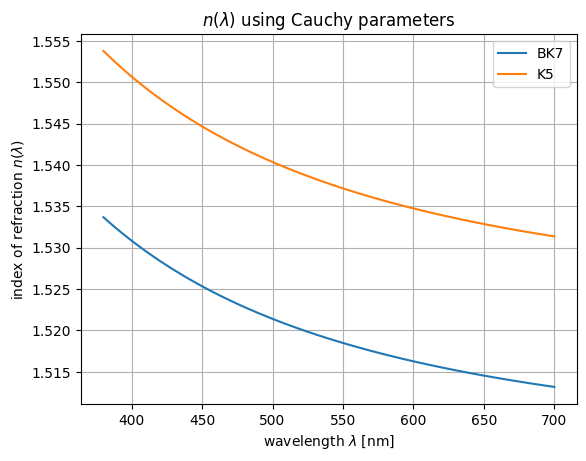

In [3]:
# Illustrate IOR for the different materials
xaxis_nm = np.linspace(380.0, 700.0, 100)

for m in ['BK7', 'K5']:
    plt.plot(xaxis_nm, ior_from_wavelength(xaxis_nm, m), label = m)
    
plt.legend()
plt.grid(True)
plt.xlabel('wavelength $\lambda$ [nm]')
plt.ylabel('index of refraction $n(\lambda)$')
plt.title('$n(\lambda)$ using Cauchy parameters' )
plt.show()

[21.371399999999994, 21.371099999999995, 21.3715]


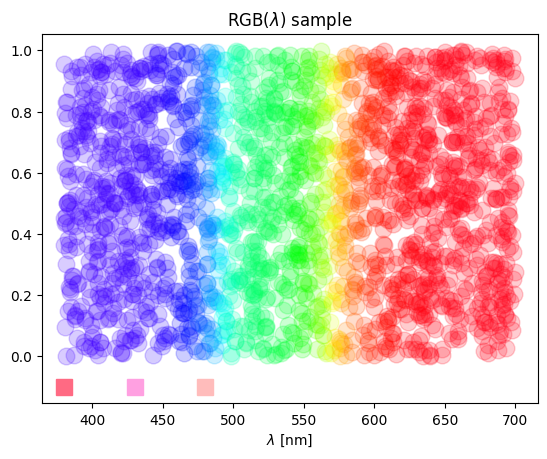

In [4]:
# Adaptation from (parts of): https://www.fourmilab.ch/documents/specrend/specrend.c
def nanometer_buckets():
    return np.linspace(380.0, 780.0, 81)

def Plambda_from_temperature(nanometers, T):  # ~ blackbody spectrum for temperature T [Kelvins] 
    lambdas = nanometers * 1.0e-9
    c1 = 3.74183e-16
    c2 = 1.4388e-2
    Plambda = (c1 / lambdas ** 5) / (np.exp(c2 / (T * lambdas)) - 1.0)
    S = np.sum(Plambda)
    return Plambda / S  # only shape is important

def XYZ_from_spectrum(Plambda): # Plambda = array of power at visible spectrum 380..780 nm for each 5nm bucket
    cie_table = [
        [0.0014,0.0000,0.0065], [0.0022,0.0001,0.0105], [0.0042,0.0001,0.0201],
        [0.0076,0.0002,0.0362], [0.0143,0.0004,0.0679], [0.0232,0.0006,0.1102],
        [0.0435,0.0012,0.2074], [0.0776,0.0022,0.3713], [0.1344,0.0040,0.6456],
        [0.2148,0.0073,1.0391], [0.2839,0.0116,1.3856], [0.3285,0.0168,1.6230],
        [0.3483,0.0230,1.7471], [0.3481,0.0298,1.7826], [0.3362,0.0380,1.7721],
        [0.3187,0.0480,1.7441], [0.2908,0.0600,1.6692], [0.2511,0.0739,1.5281],
        [0.1954,0.0910,1.2876], [0.1421,0.1126,1.0419], [0.0956,0.1390,0.8130],
        [0.0580,0.1693,0.6162], [0.0320,0.2080,0.4652], [0.0147,0.2586,0.3533],
        [0.0049,0.3230,0.2720], [0.0024,0.4073,0.2123], [0.0093,0.5030,0.1582],
        [0.0291,0.6082,0.1117], [0.0633,0.7100,0.0782], [0.1096,0.7932,0.0573],
        [0.1655,0.8620,0.0422], [0.2257,0.9149,0.0298], [0.2904,0.9540,0.0203],
        [0.3597,0.9803,0.0134], [0.4334,0.9950,0.0087], [0.5121,1.0000,0.0057],
        [0.5945,0.9950,0.0039], [0.6784,0.9786,0.0027], [0.7621,0.9520,0.0021],
        [0.8425,0.9154,0.0018], [0.9163,0.8700,0.0017], [0.9786,0.8163,0.0014],
        [1.0263,0.7570,0.0011], [1.0567,0.6949,0.0010], [1.0622,0.6310,0.0008],
        [1.0456,0.5668,0.0006], [1.0026,0.5030,0.0003], [0.9384,0.4412,0.0002],
        [0.8544,0.3810,0.0002], [0.7514,0.3210,0.0001], [0.6424,0.2650,0.0000],
        [0.5419,0.2170,0.0000], [0.4479,0.1750,0.0000], [0.3608,0.1382,0.0000],
        [0.2835,0.1070,0.0000], [0.2187,0.0816,0.0000], [0.1649,0.0610,0.0000],
        [0.1212,0.0446,0.0000], [0.0874,0.0320,0.0000], [0.0636,0.0232,0.0000],
        [0.0468,0.0170,0.0000], [0.0329,0.0119,0.0000], [0.0227,0.0082,0.0000],
        [0.0158,0.0057,0.0000], [0.0114,0.0041,0.0000], [0.0081,0.0029,0.0000],
        [0.0058,0.0021,0.0000], [0.0041,0.0015,0.0000], [0.0029,0.0010,0.0000],
        [0.0020,0.0007,0.0000], [0.0014,0.0005,0.0000], [0.0010,0.0004,0.0000],
        [0.0007,0.0002,0.0000], [0.0005,0.0002,0.0000], [0.0003,0.0001,0.0000],
        [0.0002,0.0001,0.0000], [0.0002,0.0001,0.0000], [0.0001,0.0000,0.0000],
        [0.0001,0.0000,0.0000], [0.0001,0.0000,0.0000], [0.0000,0.0000,0.0000] ]
    assert len(cie_table) == len(Plambda)
    X = 0.0
    Y = 0.0
    Z = 0.0
    for k in range(len(Plambda)):
        X += cie_table[k][0] * Plambda[k]
        Y += cie_table[k][1] * Plambda[k]
        Z += cie_table[k][2] * Plambda[k]
    return [X, Y, Z]

def xyz_from_XYZ(XYZ):
    S = np.sum(XYZ)
    return XYZ / S 

ntsc_color_system = { 'xRed'   : 0.67,   'yRed'   : 0.33, 
                      'xGreen' : 0.21,   'yGreen' : 0.71, 
                      'xBlue'  : 0.14,   'yBlue'  : 0.08, 
                      'xWhite' : 0.3101, 'yWhite' : 0.3162 }

pal_color_system  = { 'xRed'   : 0.64,   'yRed'   : 0.33, 
                      'xGreen' : 0.29,   'yGreen' : 0.60, 
                      'xBlue'  : 0.15,   'yBlue'  : 0.06, 
                      'xWhite' : 0.3127, 'yWhite' : 0.3291 }

smpte_color_system = {'xRed'   : 0.63,   'yRed'   : 0.34, 
                      'xGreen' : 0.31,   'yGreen' : 0.595, 
                      'xBlue'  : 0.155,   'yBlue' : 0.07, 
                      'xWhite' : 0.3127, 'yWhite' : 0.3291 }

defaultColorSystem = pal_color_system

def rgb_from_xyz(xyz, csys):
    def local_c_values(s):
        xs = csys['x' + s]
        ys = csys['y' + s]    
        return xs, ys, 1 - (xs + ys)
    
    xr, yr, zr = local_c_values('Red')
    xg, yg, zg = local_c_values('Green')
    xb, yb, zb = local_c_values('Blue')
    xw, yw, zw = local_c_values('White')
    
    xc = xyz[0]
    yc = xyz[1]
    zc = xyz[2]
    
    rx = (yg * zb) - (yb * zg)
    ry = (xb * zg) - (xg * zb)
    rz = (xg * yb) - (xb * yg)
    
    gx = (yb * zr) - (yr * zb)
    gy = (xr * zb) - (xb * zr)
    gz = (xb * yr) - (xr * yb)
    
    bx = (yr * zg) - (yg * zr)
    by = (xg * zr) - (xr * zg)
    bz = (xr * yg) - (xg * yr)
    
    rw = ((rx * xw) + (ry * yw) + (rz * zw)) / yw
    gw = ((gx * xw) + (gy * yw) + (gz * zw)) / yw
    bw = ((bx * xw) + (by * yw) + (bz * zw)) / yw
    
    rx = rx / rw
    ry = ry / rw
    rz = rz / rw
    
    gx = gx / gw
    gy = gy / gw
    gz = gz / gw
    
    bx = bx / bw
    by = by / bw
    bz = bz / bw
    
    rr = (rx * xc) + (ry * yc) + (rz * zc)
    gg = (gx * xc) + (gy * yc) + (gz * zc)
    bb = (bx * xc) + (by * yc) + (bz * zc)
    
    return [rr, gg, bb]

def XYZ_from_wavelength(nanometer):
    nmaxis = nanometer_buckets()
    nmdelta = np.diff(nmaxis)[0]
    power = np.exp(-0.5 * ((nmaxis - nanometer) / nmdelta) ** 2)
    power = power / np.sum(power)
    return XYZ_from_spectrum(power)

def rgb_from_wavelength(nanometer, csys = defaultColorSystem):
    XYZ = XYZ_from_wavelength(nanometer)
    xyz = xyz_from_XYZ(np.array(XYZ))
    return rgb_from_xyz(xyz, csys)

def adjust_rgb(rgb):
    rgbmin = np.min(rgb)
    if rgbmin < 0:
        rgb = rgb - rgbmin
    rgbmax = np.max(rgb)
    if rgbmax > 0:
        rgb = rgb / rgbmax
    return rgb

# A few reality checks
assert np.isclose(np.diff(nanometer_buckets())[0], 5.0)
all_spectrum = np.ones(nanometer_buckets().shape)
print(XYZ_from_spectrum(all_spectrum))

# Generate a visual representation by uniformly sampling wavelengths in the supported range
xaxis = nanometer_buckets()
plot_range = 700.0 - xaxis[0]
K = 2000
XYZ_raw_sum = np.zeros((3,))
rgb_raw_sum = np.zeros((3,))
rgb_cut_sum = np.zeros((3,))
for k in range(K):
    lambda_sample = xaxis[0] + np.random.rand() * plot_range
    XYZ_sample = XYZ_from_wavelength(lambda_sample)
    XYZ_raw_sum += XYZ_sample
    xyz_sample = xyz_from_XYZ(np.array(XYZ_sample))
    rgb_sample = rgb_from_xyz(xyz_sample, defaultColorSystem)
    rgb_procrusted = adjust_rgb(rgb_sample)
    rgb_raw_sum += np.array(rgb_sample)
    rgb_cut_sum += rgb_procrusted
    vertical_jitter = np.random.rand()
    plt.plot(lambda_sample, vertical_jitter, 
             c = rgb_procrusted, alpha = 0.20, marker = 'o', markersize = 12)

useAsWhite = adjust_rgb(rgb_from_xyz(xyz_from_XYZ(XYZ_raw_sum), defaultColorSystem))
    
plt.plot(xaxis[0], -0.10, c = adjust_rgb(rgb_raw_sum), 
         alpha = 1.0, marker = 's', markersize = 12)
plt.plot(xaxis[10], -0.10, c = adjust_rgb(rgb_cut_sum), 
         alpha = 1.0, marker = 's', markersize = 12)
plt.plot(xaxis[20], -0.10, c = useAsWhite, 
         alpha = 1.0, marker = 's', markersize = 12)
    
plt.xlabel('$\lambda$ [nm]')
plt.title('RGB($\lambda$) sample')
plt.show()

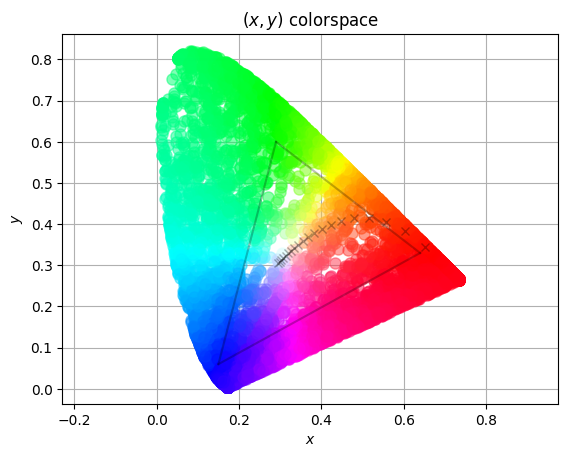

In [5]:
# Produce a representation of the full xyz color space
for k in range(500):
    lambda_sample1 = xaxis[0] + np.random.rand() * plot_range
    lambda_sample2 = xaxis[0] + np.random.rand() * plot_range
    xyz1 = xyz_from_XYZ(XYZ_from_wavelength(lambda_sample1))
    xyz2 = xyz_from_XYZ(XYZ_from_wavelength(lambda_sample2))
    for q in range(15):
        eta = np.random.rand()
        xyzq = (1 - eta) * xyz1 + eta * xyz2
        rgbq = rgb_from_xyz(xyzq, defaultColorSystem)
        plt.plot(xyzq[0], xyzq[1], c = adjust_rgb(rgbq), 
                 alpha = 0.50, marker = 'o', markersize = 8)

plt.plot([defaultColorSystem['xGreen'], defaultColorSystem['xRed']], 
         [defaultColorSystem['yGreen'], defaultColorSystem['yRed']], 
         alpha = 0.25, c = 'k')
plt.plot([defaultColorSystem['xRed'], defaultColorSystem['xBlue']], 
         [defaultColorSystem['yRed'], defaultColorSystem['yBlue']], 
         alpha = 0.25, c = 'k')
plt.plot([defaultColorSystem['xBlue'], defaultColorSystem['xGreen']], 
         [defaultColorSystem['yBlue'], defaultColorSystem['yGreen']], 
         alpha = 0.25, c = 'k')

for bbtemp in np.linspace(1000, 8000, 20):
    XYZ_bbt = XYZ_from_spectrum(Plambda_from_temperature(xaxis, bbtemp))
    xyz_bbt = xyz_from_XYZ(XYZ_bbt)
    plt.plot(xyz_bbt[0], xyz_bbt[1], 
             c = 'k', 
             alpha = 0.30, 
             marker = 'x')  # "Planck's locus"

plt.axis('equal')
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('$(x,y)$ colorspace')
plt.show()

In [6]:
# Reality check of basic geometry toolset

nAir = 1.00
nGlass = 1.50

thetai = 30.0 * np.pi / 180.0
thetat = transmitted_angle(thetai, nAir, nGlass)
R, T = fresnel_power_coefs(thetai, thetat, nAir, nGlass)

print(thetat * 180 / np.pi)
print([R, T])

u = make_unit_vector(15.0 * np.pi / 180)
v = make_unit_vector(45.0 * np.pi / 180)
assert np.isclose(get_delta_angle(u, v) * 180 / np.pi, 30.0)
assert np.isclose(get_delta_angle(v, u) * 180 / np.pi, -30.0)

19.47122063449069
[0.04152262597582152, 0.9584773740241784]


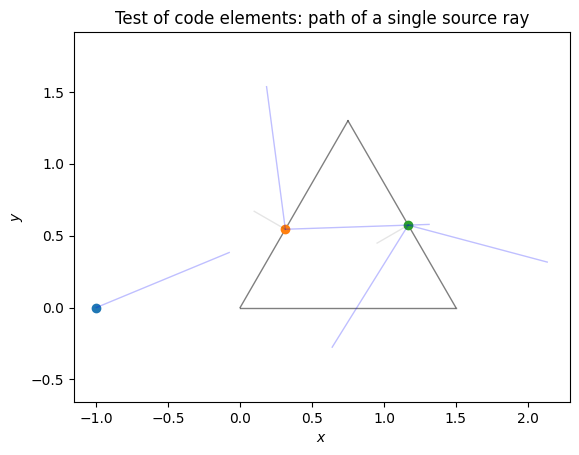

In [7]:
# Test more code elements; sketch layout of "artwork"

PA = np.array([0, 0])
PB = np.array([0.75, np.sqrt(3)/2 * 1.50])
PC = np.array([1.50, 0])

RO = np.array([-1, 0])
RV = make_unit_vector(22.5 * np.pi / 180.0)

AB = PB - PA
ABhat = AB / np.sqrt(np.sum(AB ** 2))
X = intersect_rays(RO, RV, PA, ABhat)

ABnormal = np.array([-ABhat[1], ABhat[0]])

T, R, _, _ = tr_vectors(-1 * RV, ABnormal, n1 = nAir, n2 = nGlass)

BC = PC - PB
BChat = BC / np.sqrt(np.sum(BC ** 2))
X2 = intersect_rays(X, T, PB, BChat)

BCnormal = np.array([-BChat[1], BChat[0]])

T2, R2, _, _ = tr_vectors(-1 * T, -1 * BCnormal, n1 = nGlass, n2 = nAir)

plot_triangle(PA, PB, PC, color = 'k', alpha = 0.50)
plt.plot(RO[0], RO[1], marker = 'o')
plt.plot(X[0], X[1], marker = 'o')
plt.plot(X2[0], X2[1], marker = 'o')
plot_vector(0.25 * ABnormal, X, color = 'k', alpha = 0.10)
plot_vector(RV, RO, color = 'b', alpha = 0.25)
plot_vector(R, X, color = 'b', alpha = 0.25)
plot_vector(T, X, color = 'b', alpha = 0.25)
plot_vector(-0.25 * BCnormal, X2, color = 'k', alpha = 0.10)
plot_vector(R2, X2, color = 'b', alpha = 0.25)
plot_vector(T2, X2, color = 'b', alpha = 0.25)
plt.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Test of code elements: path of a single source ray')
plt.show()

### First version of Prism artwork

As a first attempt, the wavelengths are sampled uniformly at random from the visible range and then traced for two refractions and the lines are superimposed onto the plot such that the mixing is done in RGB space. As expected, this is not quite good enough. The plot should really be generated in the XYZ colorspace and only converted to RGB at the final step.

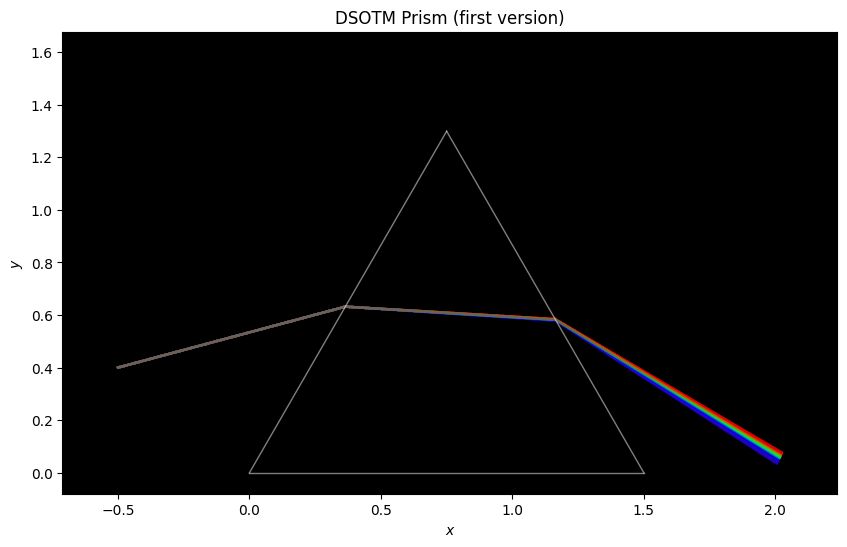

In [8]:
def trace_transmissions_12(PA, PB, PC,
                           nanometer, 
                           RayOrigin, 
                           RayVector, 
                           aa = 0.10, 
                           materialName = 'BaK4',
                           showRay = True,
                           showOR = True,
                           showIR = True,
                           lwdth = 2.0):
    nlambda = ior_from_wavelength(nanometer, materialName)
    rgbcolor = adjust_rgb(rgb_from_wavelength(nanometer))
    AB = PB - PA
    ABhat = AB / np.sqrt(np.sum(AB ** 2))
    X1 = intersect_rays(RayOrigin, RayVector, PA, ABhat)
    if showRay:
        plt.plot([RayOrigin[0], X1[0]], [RayOrigin[1], X1[1]], 
                 c = rgbcolor, alpha = aa, linewidth = lwdth)
        
    ABnormal = np.array([-ABhat[1], ABhat[0]])
    T1, R1, Reff1, Teff1 = tr_vectors(-1 * RayVector, ABnormal, n1 = nAir, n2 = nlambda)
    if showOR:
        plt.plot([X1[0], X1[0] + R1[0]], [X1[1], X1[1] + R1[1]], 
                 c = rgbcolor, alpha = aa * Reff1, linewidth = lwdth)
        
    BC = PC - PB
    BChat = BC / np.sqrt(np.sum(BC ** 2))
    X2 = intersect_rays(X1, T1, PB, BChat)
    BCnormal = np.array([-BChat[1], BChat[0]])
    T2, R2, Reff2, Teff2 = tr_vectors(-1 * T1, -1 * BCnormal, n1 = nlambda, n2 = nAir)
    plt.plot([X1[0], X2[0]], [X1[1], X2[1]], 
             c = rgbcolor, alpha = aa * Teff1, linewidth = lwdth)
    plt.plot([X2[0], X2[0] + T2[0]], [X2[1], X2[1] + T2[1]], 
             c = rgbcolor, alpha = aa * Teff1 * Teff2, linewidth = lwdth)
    if showIR:
        CA = PA - PC
        CAhat = CA / np.sqrt(np.sum(CA ** 2))
        X3 = intersect_rays(X2, R2, PC, CAhat)
        plt.plot([X2[0], X3[0]], [X2[1], X3[1]], 
                 c = rgbcolor, alpha = aa * Teff1 * Reff2, linewidth = lwdth)
        # third transmission and reflection?
        
    return X1, T1, R1, Teff1, X2, R2, T2, Teff2

plt.rcParams['figure.figsize'] = (10, 6)

fig, ax = plt.subplots()
#fig.set_facecolor('black')
ax.set_facecolor('black')

ROmod = np.array([-0.5, 0.4]) #np.array([-0.5, 0.0])
RVmod = make_unit_vector(15.0 * np.pi / 180.0) #make_unit_vector(35.0 * np.pi / 180.0)

for k in range(500):
    nm = np.random.rand() * (700.0 - 400.0) + 400.0
    X1, _, R1, Teff1, _, _, _, Teff2 = trace_transmissions_12(PA, PB, PC, 
                                                          nm, 
                                                          ROmod, 
                                                          RVmod,
                                                          aa = 1.0 / 25,
                                                          lwdth = 2.0)

plot_triangle(PA, PB, PC, color = 'white', alpha = 0.50)

plt.axis('equal')

xrange = plt.xlim()
yrange = plt.ylim()

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('DSOTM Prism (first version)')
plt.show()

### Second version of artwork

Non-uniform (blackbody) sampling of the wavelengths $\lambda$ can be used to improve the plot. Additionally, a wider beam might be visually effective. And most importantly, generate the image directly in XYZ space. Use the blackbody spectrum at $5500$ Kelvins to model a sunlight incoming beam.

[10.0, 6.0]
100.0
[1000, 600]
(-0.6262404618129453, 2.1510496980718514)
(-0.07988122780499232, 1.6775057839048386)


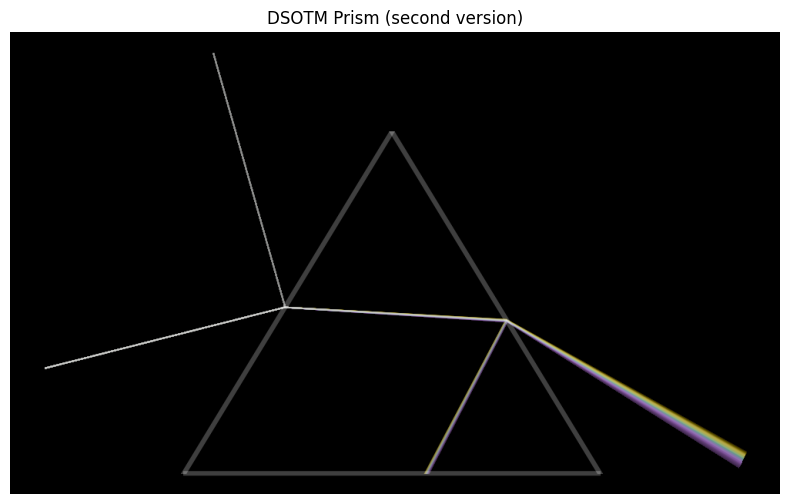

In [9]:
print(plt.rcParams['figure.figsize'])
print(plt.rcParams['figure.dpi'])

imgWidth = int(plt.rcParams['figure.figsize'][0] * plt.rcParams['figure.dpi'])
imgHeight = int(plt.rcParams['figure.figsize'][1] * plt.rcParams['figure.dpi'])

print([imgWidth, imgHeight])
print(xrange)
print(yrange)

# Convert the "raw" XYZ buffer to valid RGB with values in [0..1]
def transformBufferToRGB(buf, gamma = 1.0):
    assert buf.shape[2] == 3
    RGB = np.zeros(buf.shape)
    sumXYZ = np.sum(buf, axis = 2)
    max_sumXYZ = np.max(sumXYZ)
    if max_sumXYZ == 0.0:
        return RGB
    for chn in range(3):
        RGB[:, :, chn] = np.power(buf[:, :, chn] / max_sumXYZ, gamma)
    return RGB

def get_pixel_coords(x, y, W = imgWidth, H = imgHeight, XX = xrange, YY = yrange):
    row = H * (YY[1] - y) / (YY[1] - YY[0])
    col = W * (x - XX[0]) / (XX[1] - XX[0])
    return row, col

# useful for direct rgb mixing
def draw_numpy_line(buf, x1, y1, x2, y2, lwdth = 3.0, lcolr = [1.0, 1.0, 1.0], lalfa = 1.0):
    assert buf.shape[2] == 3
    r0, c0 = get_pixel_coords(x1, y1)
    r1, c1 = get_pixel_coords(x2, y2)
    rr, cc, vv = npdraw.weighted_line(r0, c0, r1, c1, lwdth)
    for chn in range(3):
        target = (1.0 - vv) * buf[rr, cc, chn] + vv * lcolr[chn]
        buf[rr, cc, chn] = lalfa * target + (1.0 - lalfa) * buf[rr, cc, chn]

# plain superposition per channel (normalization during post-processing)
def add_numpy_line(buf, x1, y1, x2, y2, lwdth = 3.0, lcolr = [1.0, 1.0, 1.0], lalfa = 1.0):
    assert buf.shape[2] == 3
    r0, c0 = get_pixel_coords(x1, y1)
    r1, c1 = get_pixel_coords(x2, y2)
    rr, cc, vv = npdraw.weighted_line(r0, c0, r1, c1, lwdth)
    for chn in range(3):
        buf[rr, cc, chn] += lalfa * vv * lcolr[chn]

def buffer_transmissions_12(buf,
                            PA, PB, PC,
                            nanometer, 
                            RayOrigin, 
                            RayVector, 
                            aa = 0.10, 
                            materialName = 'BaK4',
                            showRay = True,
                            showOR = True,
                            showIR = True,
                            lwdth = 2.0):
    nlambda = ior_from_wavelength(nanometer, materialName)
    XYZcolor = XYZ_from_wavelength(nanometer)
    AB = PB - PA
    ABhat = AB / np.sqrt(np.sum(AB ** 2))
    X1 = intersect_rays(RayOrigin, RayVector, PA, ABhat)
    if showRay:
        add_numpy_line(buf, RayOrigin[0], RayOrigin[1], X1[0], X1[1], ray_linewidth, XYZcolor, aa)
        
    ABnormal = np.array([-ABhat[1], ABhat[0]])
    T1, R1, Reff1, Teff1 = tr_vectors(-1 * RayVector, ABnormal, n1 = nAir, n2 = nlambda)
    if showOR:
        add_numpy_line(buf, X1[0], X1[1], X1[0] + R1[0], X1[1] + R1[1], ray_linewidth, XYZcolor, aa * Reff1)
        
    BC = PC - PB
    BChat = BC / np.sqrt(np.sum(BC ** 2))
    X2 = intersect_rays(X1, T1, PB, BChat)
    BCnormal = np.array([-BChat[1], BChat[0]])
    T2, R2, Reff2, Teff2 = tr_vectors(-1 * T1, -1 * BCnormal, n1 = nlambda, n2 = nAir)
    add_numpy_line(buf, X1[0], X1[1], X2[0], X2[1], ray_linewidth, XYZcolor, aa * Teff1)
    add_numpy_line(buf, X2[0], X2[1], X2[0] + T2[0], X2[1] + T2[1], ray_linewidth, XYZcolor, aa * Teff1 * Teff2)
    if showIR:
        CA = PA - PC
        CAhat = CA / np.sqrt(np.sum(CA ** 2))
        X3 = intersect_rays(X2, R2, PC, CAhat)
        add_numpy_line(buf, X2[0], X2[1], X3[0], X3[1], ray_linewidth, XYZcolor, aa * Teff1 * Reff2)
        # third transmission and reflection?

# Allocate rendering buffer and go!
XYZ = np.zeros((imgHeight, imgWidth, 3))

Pl = Plambda_from_temperature(xaxis, 5500.0)
assert np.all(Pl >= 0.0)
assert np.isclose(np.sum(Pl), 1.0) # NOTE: use Pl to draw from non-uniformly

ray_linewidth = 1.5
ray_alpha = 1.0 # this does not matter since it gets adapted during RGB transformation anyway

for k in range(500):
    nm = np.random.choice(nanometer_buckets(), p = Pl)  # blackbody density sample
    buffer_transmissions_12(XYZ, PA, PB, PC, nm, ROmod, RVmod, lwdth = ray_linewidth, aa = ray_alpha)

RGB = transformBufferToRGB(XYZ, gamma = 1.0 / 8.0)

# draw the prism outline directly in to RGB space (should be blended using alpha)
prism_color = [1.0, 1.0, 1.0]
prism_linewidth = 10.0
prism_alpha = 0.25

draw_numpy_line(RGB, PA[0], PA[1], PB[0], PB[1], prism_linewidth, prism_color, prism_alpha)
draw_numpy_line(RGB, PB[0], PB[1], PC[0], PC[1], prism_linewidth, prism_color, prism_alpha)
draw_numpy_line(RGB, PC[0], PC[1], PA[0], PA[1], prism_linewidth, prism_color, prism_alpha)

plt.imshow(RGB)
plt.axis('off')
plt.title('DSOTM Prism (second version)')
plt.show()

#### Conclusion

The last plot looks sort-of realistic in that the colors mix into white smoothly. There are many degrees of freedom yet unexplored how to make it more appealing. Note that the ray sampler simply ignores the third refraction whch makes it look a bit odd. A zoomed out version could be useful so that the rays gets space to diverge more; exposing colors better.